<a href="https://colab.research.google.com/github/dswh/lil_nlp_with_tensorflow/blob/main/03_03_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classifiers with CNN, LSTM and GRU


In [2]:
#importing the required libraries and APIs
#numpy to perform array based operation
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.8.0


## Downloading the headlines data, specifying the lengths, using the tokenizer



In [3]:
#downloading the headlines dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/wdd-2-node.appspot.com/x1.json \
    -o /tmp/headlines.json

In [4]:
#importing pandas to read the dataframes
import pandas as pd
data = pd.read_json("./x1.json")
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [5]:
#storing headlines and labels seperately, as it is supervised learning we need x and y mappings
headlines = list(data['headline'])
labels = list(data['is_sarcastic'])

In [6]:
#define tokenizing and padding parameters
#maximum size of the vocab we can train
vocab_size = 10000

max_length = 100

#dimesnion for embedding, we need it to show and get similarities between the vectors
embedding_dim = 64

#set the trunc type as pre or post, depending on you from where you want to truncate the sentence when it reaches the maximum length
trunc_type='post'

#padding is needed so that we hve an equal length of vectrors
padding_type='post'

#token name to fill out the words which are new and were not in our trained dictionary
oov_tok = "<OOV>"

#set the size of training
training_size = 23000

In [7]:
# getting sentences and their resoective mapped labels from 0-20000
training_sentences = headlines[0:training_size]
training_labels = labels[0:training_size]

#getting sentences for testing and their respective mapped labels from 0-20000
testing_sentences = headlines[training_size:]
testing_labels = labels[training_size:]

In [8]:
#instantiating the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

#fitting the tokenizer on texts or in a simple way we can say we are training it on our sentences
tokenizer.fit_on_texts(training_sentences)

#creating word index, for ex: i=1,love=2 and so on depending on the number of words in the training sentences we are training
word_index = tokenizer.word_index

print(word_index)

#lets see the number of unique words we have mapped 
print(len(word_index))

#After generating word indexes, we need to encode the sentence in an numbered arrayor we can say sequence, ex: if our padding=post, then I love you =[1,2,3,0,0,..... till max length]
training_sequences = tokenizer.texts_to_sequences(training_sentences)

#padding the sequence and truncating type
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#doing the same thing with testing data
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

sentence='I love'
print(tokenizer.texts_to_sequences(sentence))


{'<OOV>': 1, 'to': 2, 'of': 3, 'the': 4, 'in': 5, 'for': 6, 'a': 7, 'on': 8, 'and': 9, 'with': 10, 'is': 11, 'new': 12, 'man': 13, 'trump': 14, 'at': 15, 'from': 16, 'about': 17, 'by': 18, 'you': 19, 'after': 20, 'this': 21, 'be': 22, 'out': 23, 'up': 24, 'as': 25, 'that': 26, 'it': 27, 'how': 28, 'not': 29, 'he': 30, 'what': 31, 'are': 32, 'his': 33, 'who': 34, 'your': 35, 'just': 36, 'has': 37, 'all': 38, 'report': 39, 'will': 40, 'into': 41, 'more': 42, 'one': 43, 'year': 44, 'have': 45, 'why': 46, 'over': 47, 'u': 48, 'area': 49, 's': 50, 'woman': 51, 'says': 52, 'can': 53, 'day': 54, 'first': 55, 'like': 56, 'donald': 57, 'time': 58, 'no': 59, 'get': 60, 'old': 61, 'her': 62, 'off': 63, 'people': 64, 'life': 65, 'now': 66, "'": 67, "trump's": 68, 'house': 69, 'obama': 70, 'white': 71, 'an': 72, 'make': 73, 'back': 74, 'still': 75, 'was': 76, 'down': 77, 'if': 78, 'than': 79, 'women': 80, 'i': 81, 'my': 82, 'they': 83, 'world': 84, '5': 85, 'way': 86, 'could': 87, 'when': 88, 'clin

In [9]:
# # Now tensorflow works in arrays, so we need to convert the padded data to arrays to act as an input to our neural network
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

## Using different options for model 


In [10]:
lstm_dim=16


#now lets specify and build our model 
model = tf.keras.Sequential([
    #embedding layer taking input as vocab size=10000. dimesnion as 64, and max length as 150.                        
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),

# we have three options to use, GRU, LSTM or Convolution

#1. Bidrectional LSTM means we will be feeding the output in the both the sides, return seuences=true means we will be feeding 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

#2. we are using 1D convolution so thats basically 64 convolutions of size 5 
    #tf.keras.layers.Conv1D(64, 5, activation='relu'),

#3. we are using Gated recurrent unit and can specify the gru dimesnion 
   #tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),   


#we have two options to explore. We use global average pooling when we use convolution. We use flatten after embedding layer when we are not using any of the 3 model 
    
#1. Using flatten when you are just using embedding layer, Flatten basically converts the output from the embeddding layer into an single column of vectors    
    #tf.keras.layers.Flatten(),

#2. Gloabal average pooling just averages the pool    
   #tf.keras.layers.GlobalAveragePooling1D(),

    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         197632    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 8)                 200       
                                                                 
 dense_2 (Dense)             (None, 1)                 9

In [12]:
num_epochs = 5
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/5
719/719 - 29s - loss: 0.3844 - accuracy: 0.8193 - val_loss: 0.3166 - val_accuracy: 0.8546 - 29s/epoch - 40ms/step
Epoch 2/5
719/719 - 17s - loss: 0.1993 - accuracy: 0.9207 - val_loss: 0.3373 - val_accuracy: 0.8537 - 17s/epoch - 24ms/step
Epoch 3/5
719/719 - 17s - loss: 0.1202 - accuracy: 0.9566 - val_loss: 0.4184 - val_accuracy: 0.8566 - 17s/epoch - 24ms/step
Epoch 4/5
719/719 - 17s - loss: 0.0726 - accuracy: 0.9749 - val_loss: 0.4797 - val_accuracy: 0.8521 - 17s/epoch - 24ms/step
Epoch 5/5
719/719 - 17s - loss: 0.0461 - accuracy: 0.9846 - val_loss: 0.5871 - val_accuracy: 0.8525 - 17s/epoch - 24ms/step


## Projecting vectors in 3D and using Matlab to Visualize the data accuracy and loss

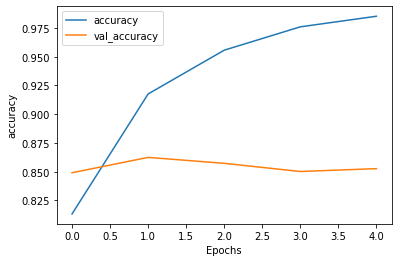

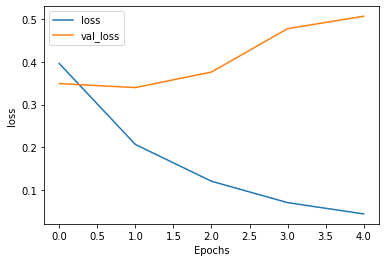

In [16]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [17]:
##isolating the first embedding layer
l1 = model.layers[0]

##extracting learned weights
weights = l1.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)
print(weights[0])

(10000, 64)
[ 4.9940306e-03 -2.3780845e-02  4.2679915e-03 -3.2756038e-03
 -9.8996395e-03  2.1067453e-03 -2.1904523e-02 -1.5220375e-02
  5.4364447e-03 -1.7485701e-02 -3.7198141e-02 -1.8997369e-02
  2.5892582e-02 -1.6600836e-02  3.3550441e-02  8.4167235e-03
  1.5363003e-02  2.0066723e-02  3.8023278e-02 -5.6865308e-03
  1.6451277e-02  5.8887475e-03 -1.0834729e-02 -2.8606323e-03
  4.1450966e-02 -1.4863636e-02  2.0296596e-02 -4.3409001e-03
  2.3078391e-02 -1.4944580e-04 -2.0236652e-02  3.2723326e-02
 -2.6128732e-02 -1.5750770e-02  3.2179482e-02 -2.7737238e-02
 -3.1535070e-02  6.8829688e-03  4.0354978e-02 -3.6045160e-02
  1.8816246e-02  2.9306727e-02  2.5686645e-03 -1.5811009e-02
  1.7044067e-02 -4.9325111e-03  7.0505223e-05 -1.4696600e-02
  2.9241152e-02  4.6662655e-02  8.0077937e-03 -9.6861636e-03
  6.8233311e-03  4.1552890e-02 -1.1373872e-02 -1.5246708e-02
 -3.9814399e-03 -7.7582211e-03  2.8820569e-02  1.3233650e-02
  2.1354923e-02 -2.5152059e-02 -2.4118328e-03  4.3513749e-02]


In [18]:
##import I/O module in python
import io

##open the text stream for vectors
vectors = io.open('vectors.tsv', 'w', encoding='utf-8')

##open the text stream for metadata
meta = io.open('meta.tsv', 'w', encoding='utf-8')

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

##write each word and its corresponding embedding
for index in range(1, vocab_size):
  word = reverse_word_index[index]  # flipping the key-value in word_index
  embeddings = weights[index]
  meta.write(word + "\n")
  vectors.write('\t'.join([str(x) for x in embeddings]) + "\n")

##close the stream
vectors.close()
meta.close()

##download the written files to your local machine
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vectors.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Classifying new sentences

In [15]:
sentence = ["game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.04648342]]
